In [1]:
# open image files
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from scipy import ndimage

d = 'sargentii_17'

files = []
for file in glob.glob(d+'/*.ti*'):
    files.append(file)

# open first image to get the image dimensions
im = np.array(Image.open(files[0]))

# define image_stack array
image_stack = np.zeros([len(files),np.shape(im)[0],np.shape(im)[1]])
# read and standardize all images
for i in range(len(files)):
    im = np.array(Image.open(files[i]))        

    image_stack[i,:,:] = im

0
0 1056 528


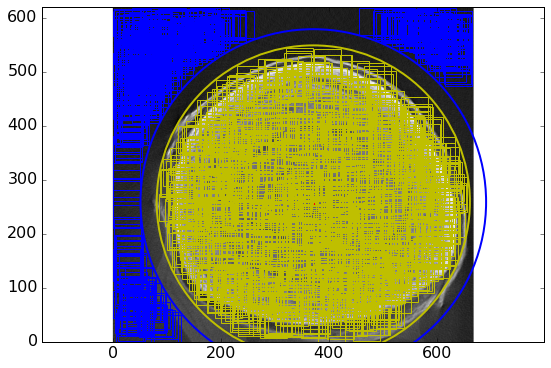

100
0 1056 528


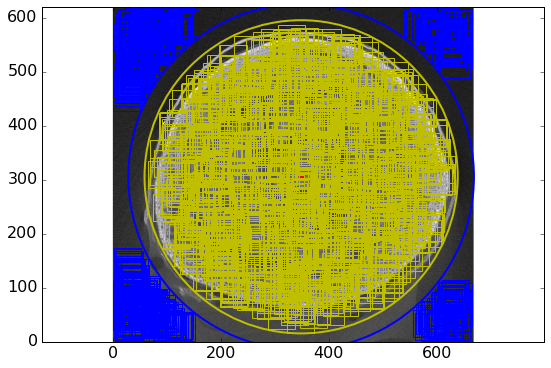

200
904 704 352


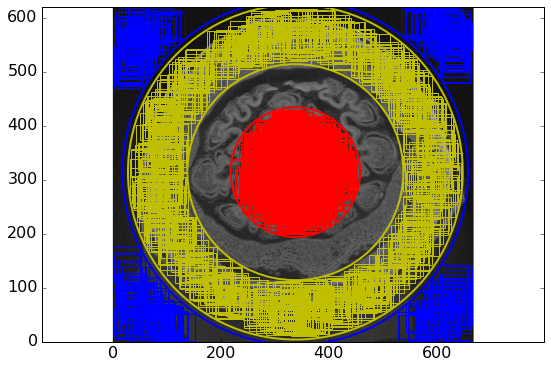

300
1413 704 352


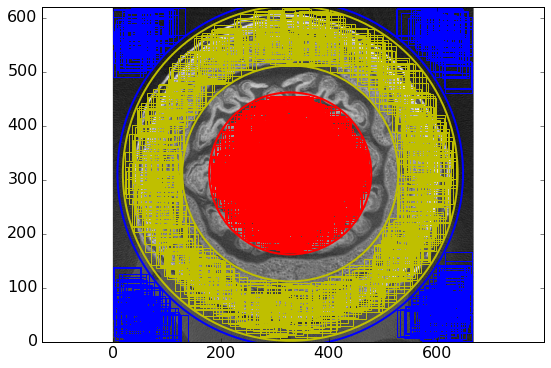

400
1413 704 352


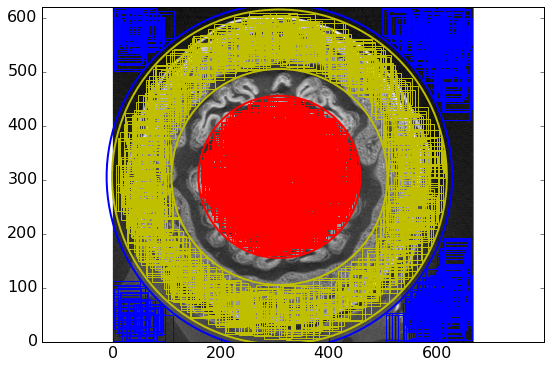

500
628 628 314


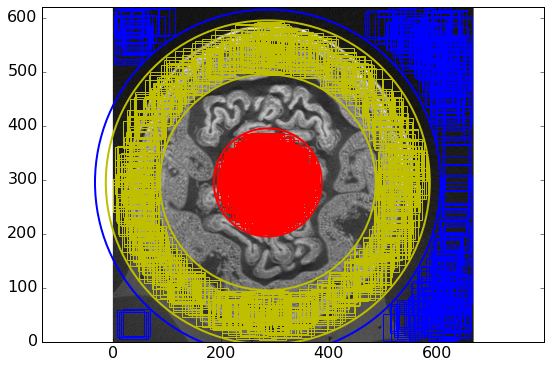

600
508 622 311


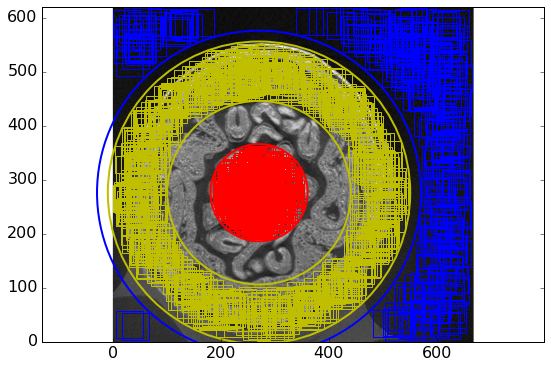

700
157 360 180


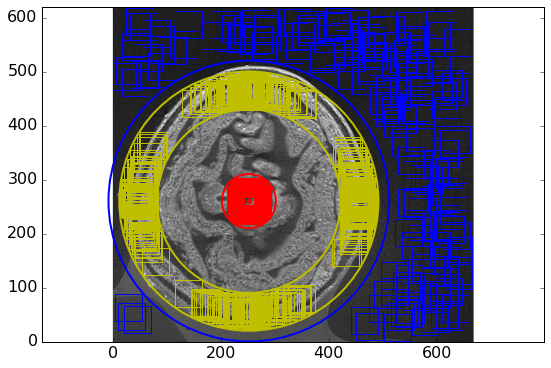

800
0 492 246


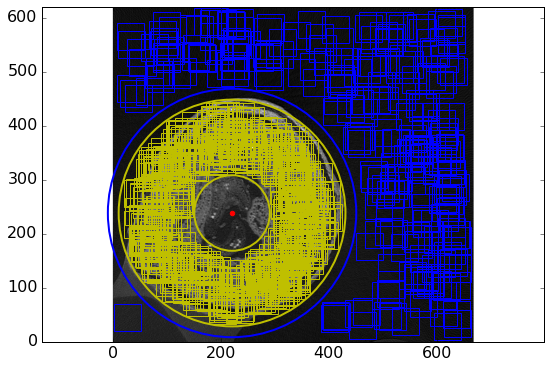

900
0 321 160


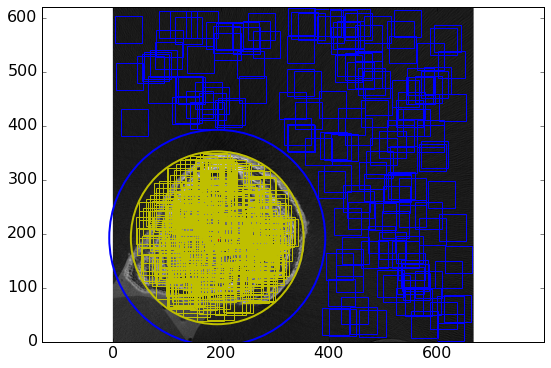

(50, 50, 14993)
(14993,)


In [2]:
# collect training data from every 100th frame
# CIRCLES

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
from skimage.measure import moments
import pickle

# size of the tiles
size = 50

frames = range(0,np.shape(image_stack)[0],100)

radii_background = np.zeros(len(frames))
radii_shell = np.zeros([len(frames),2])
radii_leaf = np.zeros(len(frames))

# radii of areas were determined by visual inspection
radii_shell[0,0] = 0
radii_shell[0,1] = 290
radii_background[0] = 320

radii_shell[1,0] = 0
radii_shell[1,1] = 290
radii_background[1] = 320

radii_leaf[2] = 120
radii_shell[2,0] = 200
radii_shell[2,1] = 310
radii_background[2] = 320

radii_leaf[3] = 150
radii_shell[3,0] = 200
radii_shell[3,1] = 310
radii_background[3] = 320

radii_leaf[4] = 150
radii_shell[4,0] = 200
radii_shell[4,1] = 310
radii_background[4] = 320

radii_leaf[5] = 100
radii_shell[5,0] = 200
radii_shell[5,1] = 300
radii_background[5] = 320

radii_leaf[6] = 90
radii_shell[6,0] = 170
radii_shell[6,1] = 280
radii_background[6] = 300

radii_leaf[7] = 50
radii_shell[7,0] = 170
radii_shell[7,1] = 240
radii_background[7] = 260

radii_shell[8,0] = 70
radii_shell[8,1] = 210
radii_background[8] = 230

radii_shell[9,1] = 160
radii_background[9] = 200

# show the frames and get the training data

tiles = np.empty(shape=[size,size,0])
labels = np.empty(shape=[0])


for f in frames:
    print f

    clustered_img = KMeans(2).fit_predict(image_stack[f,:,:].reshape([np.prod(np.shape(image_stack[f,:,:])),1]))            
    clustered_img[clustered_img == clustered_img[0]] = 2e0
    clustered_img[clustered_img != clustered_img[0]] = 3e0
    clustered_img = clustered_img - 2e0
    clustered_img = clustered_img.reshape(np.shape(image_stack[f,:,:]))
    clustered_img = np.array(clustered_img,dtype=np.double)

    m = moments(clustered_img)
    cr = m[0, 1] / m[0, 0]
    cc = m[1, 0] / m[0, 0]

    n_leaf = int(radii_leaf[f/100]**2e0*np.pi/50)
    n_shell = int((radii_shell[f/100,1]**2e0-radii_shell[f/100,0]**2e0)*np.pi/250)
    n_background = int(n_shell/2)
    
    print n_leaf,n_shell,n_background
    
    
    leaf = np.zeros([size,size,n_leaf])
    shell = np.zeros([size,size,n_shell])
    background = np.zeros([size,size,n_background])
    
    i = 0
    j = 0
    k = 0
    
    while i < n_leaf or j < n_shell or k < n_background:

        # get random pixel from the image
        x = np.random.randint(np.shape(image_stack[f,:,:])[0]-size)
        y = np.random.randint(np.shape(image_stack[f,:,:])[1]-size)

        # the distances of the corners from the center
        dist1 = np.linalg.norm(np.array([cr,cc])-np.array([x,y]))
        dist2 = np.linalg.norm(np.array([cr,cc])-np.array([x+size,y]))
        dist3 = np.linalg.norm(np.array([cr,cc])-np.array([x,y+size]))
        dist4 = np.linalg.norm(np.array([cr,cc])-np.array([x+size,y+size]))

        # check whether the corners of the square fall within any of the regions

        if np.all(np.array([dist1,dist2,dist3,dist4]) < radii_leaf[f/100]) and i < n_leaf:
            # leaf
            # get the hog features of this cell
            leaf[:,:,i] = image_stack[f,x:x+size,y:y+size]
            square = plt.Rectangle((x,y),size,size,color='r',fill=False)
            plt.gca().add_patch(square)
            i = i + 1


        if np.all(np.array([dist1,dist2,dist3,dist4]) > radii_shell[f/100,0]) and np.all(np.array([dist1,dist2,dist3,dist4]) < radii_shell[f/100,1]) and j < n_shell:
            # shell
            shell[:,:,j] = image_stack[f,x:x+size,y:y+size]
            square = plt.Rectangle((x,y),size,size,color='y',fill=False)
            plt.gca().add_patch(square)
            j = j + 1


        if np.all(np.array([dist1,dist2,dist3,dist4]) > radii_background[f/100]) and k < n_background:
            # background
            background[:,:,k] = image_stack[f,x:x+size,y:y+size]
            square = plt.Rectangle((x,y),size,size,color='b',fill=False)
            plt.gca().add_patch(square)
            k = k + 1

    tiles = np.append(tiles,np.concatenate((leaf,shell,background),axis=2),axis=2)
    label = np.concatenate((np.zeros(n_leaf)+1,np.zeros(n_shell)+2,np.zeros(n_background)))
    labels = np.append(labels,label)
    
    plt.axis('equal')
    circle1 = plt.Circle((cr,cc),radii_leaf[f/100],color='r',fill=False,lw=2)
    circle2 = plt.Circle((cr,cc),radii_shell[f/100,0],color='y',fill=False,lw=2)
    circle3 = plt.Circle((cr,cc),radii_shell[f/100,1],color='y',fill=False,lw=2)
    circle4 = plt.Circle((cr,cc),radii_background[f/100],color='b',fill=False,lw=2)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
    plt.gca().add_patch(circle4)
    
    plt.scatter(cr,cc,color='r')
    plt.xlim([0,np.shape(image_stack)[1]])
    plt.ylim([0,np.shape(image_stack)[2]])
    plt.imshow(image_stack[f,:,:].T,cmap='Greys_r')
    plt.show()
    
print np.shape(tiles)
print np.shape(labels)

# rotate the tiles and pickle dump the arrays
#new_tiles = np.append(tiles,np.rot90(tiles,k=1),axis=2)
#new_labels = np.append(labels,labels)

#new_tiles = np.append(new_tiles,np.rot90(tiles,k=2),axis=2)
#new_labels = np.append(new_labels,labels)

#new_tiles = np.append(new_tiles,np.rot90(tiles,k=3),axis=2)
#new_labels = np.append(new_labels,labels)

#print np.shape(new_tiles)
#print np.shape(new_labels)

file_name = 'data_files/training_data_'+str(size)+'x'+str(size)+'.dat'
f = open(file_name,'w')
pickle.dump([tiles,labels],f)
f.close()


In [2]:
# collect training data from every 100th frame
# POLYGON

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib inline
#matplotlib.rcParams.update({'font.size': 16})
#matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
from skimage.measure import moments
import pickle

# size of the tiles
size = 50

frames = range(0,np.shape(image_stack)[0],100)

# show the frames and click around the background/shell and shell/leaf boundary

background_shell = []

for f in frames:
    # show image and click around the background/shell boundary first
    # LEAVE ENOUGH SPACE such that there will be shell tiles on the exact boundary
    # click as many times as you'd like. the first and last clicks will be connected to close the boundary
    # press enter to terminate clicking
    plt.title('Click on the background - shell boundary')
    plt.axis('equal')
    plt.xlim([0,np.shape(image_stack[f,:,:])[0]])
    plt.ylim([0,np.shape(image_stack[f,:,:])[1]])
    plt.imshow(image_stack[f,:,:].T,cmap='Greys_r')
    coord = plt.ginput(n=-1,timeout=-1)
    plt.close()
    background_shell.append(coord)
    
    
shell_leaf = []
for f in frames:
    # show image and click around the shell-leaf boundary 
    # click as many times as you'd like. the first and last clicks will be connected to close the boundary
    # press enter to terminate clicking
    plt.title('Click on the shell-leaf boundary')
    plt.axis('equal')
    plt.xlim([0,np.shape(image_stack[f,:,:])[0]])
    plt.ylim([0,np.shape(image_stack[f,:,:])[1]])
    plt.imshow(image_stack[f,:,:].T,cmap='Greys_r')
    coord = plt.ginput(n=-1,timeout=-1)
    plt.close()
    shell_leaf.append(coord)

file_name = 'data_files/shell_leaf_boundaries_'+str(size)+'x'+str(size)+'.dat'
f = open(file_name,'w')
pickle.dump([background_shell,shell_leaf],f)
f.close()


In [7]:
# get the training data
from skimage.measure import points_in_poly


file_name = 'data_files/shell_leaf_boundaries_'+str(size)+'x'+str(size)+'.dat'
f = open(file_name,'r')
[background_shell,shell_leaf] = pickle.load(f)
f.close()

tiles = np.empty(shape=[size,size,0])
labels = np.empty(shape=[0])

for f in range(len(frames)):

    # calculate leaf and shell areas
    coord = shell_leaf[f]
    if len(coord) > 0:
        x = [c[0] for c in coord]
        y = [c[1] for c in coord]
        x_leaf = np.append(x,x[0])
        y_leaf = np.append(y,y[0])
        area_leaf = np.abs(np.sum(x_leaf[:-1]*y_leaf[1:]-y_leaf[:-1]*x_leaf[1:]))/2e0
    else:
        x_leaf = 0
        y_leaf = 0
        area_leaf = 0e0

    coord = background_shell[f]
    x = [c[0] for c in coord]
    y = [c[1] for c in coord]
    x_shell = np.append(x,x[0])
    y_shell = np.append(y,y[0])
    area_shell = np.abs(np.sum(x_shell[:-1]*y_shell[1:]-y_shell[:-1]*x_shell[1:]))/2e0 - area_leaf
    
    # estimate number of tiles based on the area

    n_leaf = int(area_leaf/80)
    n_shell = int(area_shell/270)
    n_background = int(n_shell/2)
    
    print f,n_leaf,n_shell,n_background

    leaf = np.zeros([size,size,n_leaf])
    shell = np.zeros([size,size,n_shell])
    background = np.zeros([size,size,n_background])

    i = 0
    j = 0
    k = 0

    while i < n_leaf or j < n_shell or k < n_background:

        # get random pixel from the image
        x = np.random.randint(np.shape(image_stack[frames[f],:,:])[0]-size)
        y = np.random.randint(np.shape(image_stack[frames[f],:,:])[1]-size)

        # check whether all the corners of the square fall within any of the regions
        
        corners = np.zeros([4,2])
        corners[0,:] = [x,y]
        corners[1,:] = [x+size,y]
        corners[2,:] = [x,y+size]
        corners[3,:] = [x+size,y+size]    
        
        
        if np.all(points_in_poly(corners,np.column_stack((x_leaf,y_leaf)))) and i < n_leaf:
            # leaf
            # get the hog features of this cell
            leaf[:,:,i] = image_stack[frames[f],x:x+size,y:y+size]
            square = plt.Rectangle((x,y),size,size,color='r',fill=False)
            plt.gca().add_patch(square)
            i = i + 1


        if np.all(points_in_poly(corners,np.column_stack((x_shell,y_shell)))) and np.all(~points_in_poly(corners,np.column_stack((x_leaf,y_leaf)))) and j < n_shell:
            # shell
            shell[:,:,j] = image_stack[frames[f],x:x+size,y:y+size]
            square = plt.Rectangle((x,y),size,size,color='y',fill=False)
            plt.gca().add_patch(square)
            j = j + 1


        if np.all(~points_in_poly(corners,np.column_stack((x_shell,y_shell)))) and k < n_background:
            # background
            background[:,:,k] = image_stack[frames[f],x:x+size,y:y+size]
            square = plt.Rectangle((x,y),size,size,color='b',fill=False)
            plt.gca().add_patch(square)
            k = k + 1

    tiles = np.append(tiles,np.concatenate((leaf,shell,background),axis=2),axis=2)
    label = np.concatenate((np.zeros(n_leaf)+1,np.zeros(n_shell)+2,np.zeros(n_background)))
    labels = np.append(labels,label)

    plt.axis('equal')

    plt.xlim([0,np.shape(image_stack)[1]])
    plt.ylim([0,np.shape(image_stack)[2]])
    plt.imshow(image_stack[frames[f],:,:].T,cmap='Greys_r')
    plt.savefig('imgs/shell_leaf_boundaries+'+str(frames[f])+'.png',dpi=150)
    plt.close()


print np.shape(tiles)
print np.shape(labels)
print len(labels[labels == 1]),len(labels[labels == 2]),len(labels[labels == 0])

# rotate the tiles and pickle dump the arrays
#new_tiles = np.append(tiles,np.rot90(tiles,k=1),axis=2)
#new_labels = np.append(labels,labels)

#new_tiles = np.append(new_tiles,np.rot90(tiles,k=2),axis=2)
#new_labels = np.append(new_labels,labels)

#new_tiles = np.append(new_tiles,np.rot90(tiles,k=3),axis=2)
#new_labels = np.append(new_labels,labels)

#print np.shape(new_tiles)
#print np.shape(new_labels)

file_name = 'data_files/training_data_'+str(size)+'x'+str(size)+'.dat'
f = open(file_name,'w')
pickle.dump([tiles,labels],f)
f.close()

0 0 1092 546
1 846 905 452
2 1131 899 449
3 1295 886 443
4 1297 840 420
5 944 834 417
6 704 787 393
7 344 747 373
8 126 606 303
9 0 412 206
(50, 50, 18697)
(18697,)


6687 8008 4002


In [9]:
#do PCA
import numpy as np
import pylab as plt
'''
Performs the Principal Coponent analysis of the Matrix X
Matrix must be n * m dimensions
where n is # features
m is # examples
'''

def PCA(X, varRetained = [0.95],filename = 'PCA_data.dat'):

    # Compute Covariance Matrix Sigma
    (n, m) = X.shape

    Sigma = 1.0 / float(m) * np.dot(X, np.transpose(X))
    # Compute eigenvectors and eigenvalues of Sigma
    U, s, V = np.linalg.svd(Sigma)

    # compute the value k: number of minumum features that 
    # retains the given variance
    s_tot = np.sum(s)
        
    var_i = np.array([np.sum(s[: i + 1]) / s_tot * 100.0 for i in range(n)])
    
    k = np.zeros(len(varRetained))
    for i in range(len(k)):
        k[i] = len(var_i[var_i < (varRetained[i] * 100e0)])

        print '%.2f %% variance retained in %d dimensions' % (var_i[k[i]], k[i])

        # compute the reduced dimensional features 
        U_reduced = U[:, : k[i]]
        Z = np.dot(np.transpose(U_reduced),X)

        # pickle dump the results
        f = open(filename+str(int(varRetained[i]*100e0))+'.dat','w')
        pickle.dump([Z, U_reduced, k[i]],f)
        f.close() 

    return 


var_ret = [0.80, 0.85, 0.90, 0.95, 0.99] 

# load the training data and divide it to training (60%), test (20%), and cross validation (20%) sets
f = open('data_files/training_data_'+str(size)+'x'+str(size)+'.dat','r')
[tiles,labels] = pickle.load(f)
f.close()


# standardize tiles
tiles_standard = np.zeros(np.shape(tiles))

mean = np.mean(image_stack)
std = np.std(image_stack)
for i in range(len(labels)):
    tiles_standard[:,:,i] = (tiles[:,:,i] - mean) / std

# reshape tiles
reshape_tiles = np.reshape(tiles_standard,[size*size,len(labels)])

filename = 'data_files/PCA_data_'+str(size)+'x'+str(size)+'_var0'

# do PCA and save the results
PCA(reshape_tiles,varRetained = var_ret,filename = filename)

print 'finished'



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


80.56 % variance retained in 12 dimensions
85.30 % variance retained in 21 dimensions
90.03 % variance retained in 36 dimensions
95.04 % variance retained in 83 dimensions
99.00 % variance retained in 339 dimensions
finished


In [ ]:
# run the SVM

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
import pickle
from scipy.misc import imresize

# number of simulations 
n_sim = 10

var = 0.99

file_name = 'data_files/training_data_'+str(size)+'x'+str(size)+'.dat'
f = open(file_name,'r')
[X,Y] = pickle.load(f)
f.close()  


f = open('data_files/PCA_data_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','r')
[Z, U_reduced, k] = pickle.load(f)
f.close()


# range of C and gamma values
# the range used to be wider: -8e0,3e0 with num = 12
# experience showed that the best C is within this reduced range usually
C = 10e0**(np.linspace(0e0,4e0,5))
gamma = 10e0**(np.linspace(-4e0,0e0,5))

train_score = np.zeros([n_sim,len(C),len(gamma)])
test_score = np.zeros([n_sim,len(C),len(gamma)])
CV_score = np.zeros([n_sim,len(C),len(gamma)])

for i in range(n_sim):
    print '   ',i
    # shuffle and split data
    indx = np.arange(np.shape(Z.T)[0])
    np.random.shuffle(indx)
    # split 60-20-20%
    split1 = int(np.shape(Z.T)[0]*0.6)
    split2 = int(np.shape(Z.T)[0]*0.8)
    X_train = Z.T[indx[:split1]]
    Y_train = Y[indx[:split1]]
    X_test = Z.T[indx[split1:split2]]
    Y_test = Y[indx[split1:split2]]
    X_CV = Z.T[indx[split2:]]
    Y_CV = Y[indx[split2:]]


    # train SVM and loop through all C and gamma combinations
    for j in range(len(C)):
        for k in range(len(gamma)):
            #print '      C and gamma:',C[j],gamma[k]
            SVC_bud = SVC(kernel='rbf', C=C[j], gamma=gamma[k]).fit(X_train, Y_train)            
            train_score[i,j,k] = SVC_bud.score(X_train,Y_train)
            test_score[i,j,k] = SVC_bud.score(X_test,Y_test)
            CV_score[i,j,k] = SVC_bud.score(X_CV,Y_CV)


    # find the C and gamma parameters that give max score.
    # if there are multiple parameter configuration giving max score, the first one of these is used below 
    best_params = np.where(test_score[i,:,:] == np.max(test_score[i,:,:]))
    print '   best C value(s):',C[best_params[0]]
    print '   best gamma value(s):',gamma[best_params[1]]
    print '   max test score:',np.max(test_score[i,:,:])



avg_score = np.mean(test_score[:,:,:],axis=0)
avg_CV_score = np.mean(CV_score[:,:,:],axis=0)
std_CV_score = np.std(CV_score[:,:,:],axis=0)

best_params = np.where(avg_score == np.max(avg_score))
print 'best C value(s):',C[best_params[0]]
print 'best gamma value(s):',gamma[best_params[1]]
print 'max test score:',np.max(avg_score)

print 'CV score:',avg_CV_score[best_params],'+/-',std_CV_score[best_params]
# train the best SVM and save it
SVC_bud = SVC(kernel='rbf', C=C[best_params[0][0]], gamma=gamma[best_params[1][0]]).fit(Z.T, Y)            


# save the results
f = open('data_files/SVM_tile_scores_nsim'+str(n_sim)+'_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','w')
pickle.dump([test_score,train_score,CV_score,SVC_bud,C,gamma],f)
f.close()



    0


In [ ]:
# go through the image stack and render the classes

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
from skimage.util.shape import view_as_windows
import pickle
from skimage import measure
from skimage.filters import gaussian_filter


step_size = 10

f = open('data_files/PCA_data_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','r')
[Z, U_reduced, k] = pickle.load(f)
f.close()

f = open('data_files/SVM_tile_scores_nsim10_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','r')
[test_score,train_score,CV_score,SVC_bud,C,gamma] = pickle.load(f)
f.close()

windows = view_as_windows(image_stack[0,:,:],(size,size))


f_range = np.arange(np.shape(image_stack)[0],step=step_size)
i_range = np.arange(np.shape(windows)[0],step=step_size)
j_range = np.arange(np.shape(windows)[1],step=step_size)

class_stack = np.zeros([len(f_range),len(i_range),len(j_range)]).astype(int)

mean_im = np.mean(image_stack)
std_im = np.std(image_stack)
for f in range(len(f_range)):
    if f%50 == 0:
        print f

    windows = view_as_windows(image_stack[f_range[f],:,:],(size,size))
    
    PCA_features = np.zeros([len(i_range),len(j_range),np.shape(Z)[0]])
    # collect the PCA features
    for i in range(len(i_range)):
        for j in range(len(j_range)):
            tile_standard = (windows[i_range[i],j_range[j]] - mean_im)/std_im
            reshape_tile = tile_standard.reshape(size*size)
            PCA_features[i,j,:] = np.dot(reshape_tile,U_reduced)

    # predict the classes:
    for i in range(len(i_range)):
        class_stack[f,i,:] = SVC_bud.predict(PCA_features[i,:,:])
        
    class_stack[f,:,:][class_stack[f,:,:] == 2] = 0
    
    if f%(100/step_size) == 0:
    
        plt.figure(figsize=(12,6))
        plt.subplot(1, 2, 1)
        plt.axis('equal')
        plt.xlim([0,np.shape(image_stack[f_range[f],:,:])[0]])
        plt.ylim([0,np.shape(image_stack[f_range[f],:,:])[1]])
        plt.imshow(image_stack[f_range[f],:,:],cmap='Greys_r')

        plt.subplot(1, 2, 2)
        plt.xlim([0,np.shape(class_stack[f,:,:])[0]])
        plt.ylim([0,np.shape(class_stack[f,:,:])[1]])
        plt.imshow(class_stack[f,:,:])
        plt.savefig('animation_border/contours_size'+str(size)+'_tile'+str(f_range[f])+'.png',dpi=150)
        plt.close()

f = open('data_files/class_stack_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','w')
pickle.dump([class_stack],f)
f.close()


In [ ]:
# go through the class stack and select the contours
# ffmpeg -framerate 25 -i contours_tiles_frame%04d_size50.png -s:v 750x750 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ani_contours.mp4

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
from sklearn.svm import SVC
from skimage.util.shape import view_as_windows
import pickle
from skimage import measure
from skimage.filters import gaussian_filter

f = open('data_files/class_stack_'+str(size)+'x'+str(size)+'_var0'+str(int(var*100e0))+'.dat','r')
[class_stack] = pickle.load(f)
f.close()

frames = np.arange(0,10)*100

#for f in frames:
for f in range(np.shape(image_stack)[0]):
    
    if f%50 == 0:
        print f
    
    smoothed = gaussian_filter(class_stack[f/step_size,:,:].astype(float),sigma=1)
    
    contours = measure.find_contours(smoothed, 0.5)
    
    plt.axis('equal')
    plt.xlim([0,np.shape(image_stack[f,:,:])[0]])
    plt.ylim([0,np.shape(image_stack[f,:,:])[1]])
    
    if len(contours) != 0:
    
        # calculate the area of the contours
        area = np.zeros(len(contours))

        for n, contour in enumerate(contours):
            x = contour[:,0]
            y = contour[:,1]
            # copy the first point to the end of the contour list to close the loop
            x = np.append(x,x[0])
            y = np.append(y,y[0])
            # use Green's theorem to calculate the area of the contour
            area[n] = np.abs(np.sum(x[:-1]*y[1:]-y[:-1]*x[1:]))/2e0

        # find contour with the largest area
        cont = contours[np.where(area == np.max(area))[0]]

        plt.plot(size/2e0+cont[:, 1]*step_size, size/2e0+cont[:, 0]*step_size,color='r', linewidth=2) 
        #for n, contour in enumerate(contours):
        #    plt.plot(size/2e0+contour[:, 1]*step_size, size/2e0+contour[:, 0]*step_size,color='r', linewidth=1) 

    plt.imshow(image_stack[f,:,:],cmap='Greys_r',vmin=0,vmax=66000)
    plt.savefig('animation_border/tile'+str(size)+'/contours_tiles_frame'+str(f).zfill(4)+'_size'+str(size)+'.jpg',dpi=100)
    plt.close()
    

